![](https://i.imgur.com/HL4sH99.png)
## House Prices: Statistical and Data Analysis

###  Goal/Problem Statement: How can we make at least a 10% profit on our investments?


---

Context: We are flipping homes to turn a quick profit and are trying to figure out which upgrades/renovations lead to the greatest increase in Sales Price. <br>
<br>Criteria for Success: 10% increase in price from initial purchase price.<br>
<br>Scope of Solution Space: We are focusing on the difference in sale price from initial purchase price to new price after renovations and upgrades have been made to the home. We will focus on aspects that we have control over such as bathrooms, finished garages, among other similiar upgrades.<br>
<br>Constraints within Solution Space: We must be aware of not adding any square footage to the homes as well as the opportunity-cost to upgrade the home (the upgrade must increase new sale price by 10% more than the initial purchase price).<br>
<br>Stakeholders to Provide Key Insight: The stakeholders will be us as we are purchasing the homes and upgrading them in order to significantly increase price and our contractor as his expertise deals with the execution of the upgrades.<br>
<br>Key Data Sources: We will be getting our data from Kaggle. We are using The Ames Housing dataset which was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.<br>


***

# ISSUE TREE

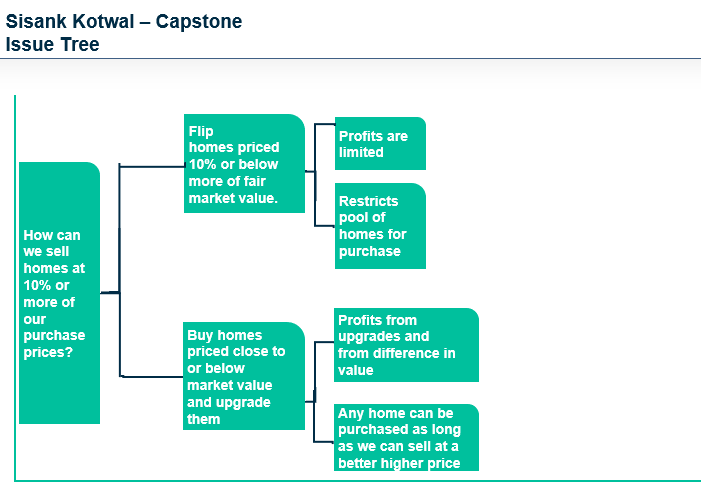

***

## <span style="color:blue">Importing Libraries</span> 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

## <span style="color:blue"> Load Data and Create Dataframe</span> 

In [ ]:
train = pd.read_csv("../input/train2csv/train2.csv", header=0)

## <span style="color:blue">Data Cleansing </span>
    
### The goal is to remove redundant variables, keep only necessary variables for analysis, remove categorical variables, and remove rows where data is incomplete.


In [ ]:
df_train = train.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
df_train.head(10)

### In the following step, I will remove unnecessary variables and/or combine variables that can be added together, as well as look at the remaining variables' descriptive statistics.

In [ ]:
#Combine WoodDeck SF, OpenPorchSF, and EnclosedPorch, 3SsnPorch, and ScreenPorch into one variable: PorchSF
df_train.loc[:,'PorchSF'] = df_train.loc[:,'OpenPorchSF'].add(df_train.loc[:,'EnclosedPorch']).add(df_train.loc[:,'WoodDeckSF']).add(df_train.loc[:,'3SsnPorch']).add(df_train.loc[:,'ScreenPorch'])

#make new dataframe with only numerical variables and dropping the variables that we added to make PorchSF

df_train2 = df_train.drop(['HouseStyle', 'ExterQual', 'WoodDeckSF', 'OpenPorchSF',
                           'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'Neighborhood'], axis=1)

df_train2 = df_train2.apply (pd.to_numeric, errors='coerce')
df_train2 = df_train2.dropna()
df_train2 = df_train2.reset_index(drop=True)

# <span style="color:blue">EDA </span>

### We will now explore and analyze the data.

In [ ]:
#finding the descriptive statistics of our variables
df_train2.describe()

In [ ]:
#Searching for any abnormalities with SalePrice distribution using histograms and experimenting with bins.

plt.rcParams['figure.figsize'] = (15,4)
plt.subplot(1,2,1)
sns.distplot(df_train2['SalePrice'])

plt.subplot(1,2,2)
sns.distplot(df_train2['SalePrice'], bins=100)

print("When looking at the histogram we see the data for SalePrice skews to the right. This shows us that the mean is greater than the median SalePrice because of the few homes' prices that push the average higher.")
print()
print("IMPORTANT: Analyzing the second histogram where we used our own bins instead of using the default calculated by Seaborn, we notice highs and lows in the distribution. This may be explained by psychological price points the houses were listed under in order to entice home buyers.")

In [ ]:
plt.subplot(1,1,1)
plt.rcParams['figure.figsize'] = (15,4)
plt.xticks(rotation='45')
sns.boxplot(data=df_train2)
plt.title("Boxplot for all attributes")
plt.show()

print('We look at the boxplots for all attributes and visually determine which variables we assume are most likely correlated to SalePrice')

BoxPlotFilt = ['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'YrSold']
plt.subplot(2,1,2)
plt.rcParams['figure.figsize'] = (15,4)
plt.xticks(rotation='45')
sns.boxplot(data=df_train2[BoxPlotFilt])
plt.title("Boxplot for variables most likely related to SalePrice.")
plt.show()

print("There seems to be a lot of outliers in SalePrice. Let's remove them and see if there are enough remaining data points to continue our analysis without the outliers.")

In [ ]:
Q1 = df_train2.quantile(0.25)
Q3 = df_train2.quantile(0.75)

IQR = Q3-Q1

df_No_Outliers = df_train2[~((df_train2 < (Q1 - 1.5 * IQR)) |(df_train2 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_No_Outliers.shape[0])

merged_dataframe_proportion = df_No_Outliers.shape[0]/df_train2.shape[0]

print("When we have not removed any outliers from the dataset, we have " + str(df_train2.shape[0]) + " entries.") 

print("When we remove outliers from the dataset, we have " + str(df_No_Outliers.shape[0]) + " entries.")
print("The proportion of entries that are not outliers compared to the dataframe is " + str(round(merged_dataframe_proportion*100,2))+"%")

### Because almost half of the entries are outliers, I will choose to include all entries in my regression model. For now, we will use visualizations to find insights, specifically the variables' correlation to SalePrice. Ultimately, we will use a correlation matrix to find which variables have strong correlation to SalePrice.

# <span style="color:blue"> Insights </span> - <span style="color:black">Let's look for insights now that we've cleaned our data</span> 


### Let's create scatter plots to eyeball correlation.

In [ ]:
#creating scatter plots to see if we can see correlation via this type of visual

x_col = df_train2['SalePrice'].reset_index(drop=True)

y_columns = df_train2.drop(columns=['SalePrice']).reset_index(drop=True)

for i in y_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df_train2['SalePrice'], df_train2[i])
    ax.set_xlabel('SalePrice')
    ax.set_ylabel(i)
    plt.show()

print("There are some variables that look to be correlated and some that don't. Using a correlation matrix will give us the best visualization to determine the relationships between SalePrice and the other variables.")


### It's also important to note that this dataset shows SalePrices before, during, and after the Great Recession, when the housing bubble popped. This means house prices were extremely inflated before the crisis and popped right after, leading to divergence in prices when the housing market bubble was being inflated to when it popped.

In [ ]:
#building correlation matrix heatmap

df_train2 = df_train2.drop(['YrSold'], axis=1)

df_train2 = df_train2.apply (pd.to_numeric, errors='coerce')
df_train2 = df_train2.dropna()
df_train2 = df_train2.reset_index(drop=True)

df_train2_corr = df_train2.corr()

plt.figure(figsize=(20,16))
ax = sns.heatmap(df_train2_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### There is a lot to look at in the correlation matrix. Let's simplify it by looking only at SalePrice and ordering correlation in descending order and creating a nice visual to help us picture the differences.

In [ ]:
#Order the correlation of each variable to SalePrice in descending order and create a bar chart to display the degree of correlation

row = df_train2_corr.loc[:,['SalePrice']]
row = row.sort_values(by='SalePrice', ascending=False).drop('SalePrice')

plt.figure(figsize=(20,8))
sns.barplot(data=row, x = row.index, y = 'SalePrice')
plt.xticks(rotation='45')

print(row)

### Looks like about 1/3rd of the variables show strong correlation to SalePrice, but I doubt that is truly the case. 
### We'll run regression analysis and see which variables we should keep through this analysis.

In [ ]:
X = df_train2.drop(['SalePrice'], axis=1) #We now have only independent variables here without any dependent variables. 
X = sm.add_constant(X) #We've added our constant intercept to our independent variable dataframe

#We've specified SalePrice to the Y Dataframe
#We fit the model below using the statsmodel (denoted by SM) OLS function.
OLSmodel = sm.OLS(df_train2['SalePrice'], X)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

### Based off of the OLS Regression Results, we can easily see the variables that stand out and most affect SalePrice because their coefficients are much greater in absolute terms.

### The variables that affect SalesPrice the most are OverallQual, OverallCond, YearBuilt, MasVnrArea, BsmtUnfSF, GrLivArea, BsmtFullBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, and GarageCars. For some reason BedroomAbvGr and KitchenAbvGr affects price negatively, but I doubt that is the case in reality. They are probably only negative to help us calculate the SalePrice of a home when we have all the variables accounted for. 

### On that note, it's important to realize that just because a variable has a high coefficient, it may not have an acceptable p-value. It is important that we only pick variables with acceptable p-values. 

### Since, we have a lot of variables we are prone to overfitting if we use all of these variables in our regression model, let's remove those with an unacceptable p-value.

In [ ]:
#create a filter that only has variables with a correlation greater than .50 to SalePrice

filt1 = ['OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtUnfSF', 'GrLivArea',
         'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'SalePrice'] 

X = df_train2[filt1].drop(['SalePrice'], axis=1) #We now have only independent variables here without any dependent variables. 
X = sm.add_constant(X) #We've added our constant intercept to our independent variable dataframe

#We've specified SalePrice to the Y Dataframe
#We fit the model below using the statsmodel (denoted by SM) OLS function.
OLSmodel = sm.OLS(df_train2['SalePrice'], X)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

### We've kept all variables with acceptable p-values, but we are finding that BedroomAbvGr and KitchenAbvGr are still negatively correlated to SalePrice and now we see that MsntUnfSF has an unacceptable p-value. Let's remove these variables and see happens to our R-squared value. 

In [ ]:
filt2 = ['OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'GrLivArea',
         'BsmtFullBath', 'TotRmsAbvGrd', 'GarageCars', 'SalePrice'] 

X = df_train2[filt2].drop(['SalePrice'], axis=1) #We now have only independent variables here without any dependent variables. 
X = sm.add_constant(X) #We've added our constant intercept to our independent variable dataframe

#We've specified SalePrice to the Y Dataframe
#We fit the model below using the statsmodel (denoted by SM) OLS function.
OLSmodel = sm.OLS(df_train2['SalePrice'], X)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

### Now we see that TotRmsAbvGrd has a negative coefficient and a very high p-value. We must take it out to make our equation even better.

In [ ]:
filt2 = ['OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'GrLivArea',
         'BsmtFullBath', 'GarageCars', 'SalePrice'] 

X = df_train2[filt2].drop(['SalePrice'], axis=1) #We now have only independent variables here without any dependent variables. 
X = sm.add_constant(X) #We've added our constant intercept to our independent variable dataframe

#We've specified SalePrice to the Y Dataframe
#We fit the model below using the statsmodel (denoted by SM) OLS function.
OLSmodel = sm.OLS(df_train2['SalePrice'], X)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

In [ ]:

plt.rcParams['figure.figsize'] = (15,4)


RegressionResults=OLSmodelResult.predict(X)
print(RegressionResults)

fig, ax1 = plt.subplots()

ax1.get_xaxis().set_visible(False)
ax1.set_ylabel('Regression Result', color='navy')
ax1.plot(RegressionResults, color='navy') 
ax1.set_ylabel('SalePrice', color='red')
ax1.plot(df_train2['SalePrice'], color='red')

### We can find homes values based off of the regression model we made and compare their market price to our model's price in order to look for a good deal or undervalued home. It will be accurate 77.5% of the time.

### We also see that the overall condition of the home is the biggest factor in price. If a home has room to be fixed and improved so that overall condition is rated higher, then the home has great potential to be sold for more than it was bought. 

### The best thing about this model is that it takes it only takes into account variables with p-values less than .001 meaning that less than .1% of our results will happen by chance.

# <span style="color:blue"> Key Takeways </span>

In [ ]:
#reload data so we can have a clean start again with the same raw data
#adding new variables from our EDA into the table 

train = pd.read_csv("../input/train2csv/train2.csv", header=0)

df_train2.loc[:,'RegressionResults'] = RegressionResults
df_train2 = pd.merge(df_train2,train,on='Id')

df_train2["RegressionResults"].astype(int)
df_train2["SalePrice_x"].astype(int)

Variance = df_train2["RegressionResults"] - df_train2["SalePrice_x"]
df_train2.loc[:,'Variance'] = Variance
df_train2["Variance"].astype(int)

Variance_PCT = Variance/df_train2["SalePrice_x"]
df_train2.loc[:,'Variance_PCT'] = Variance_PCT
df_train2['Variance_PCT'].astype(int)

df_train2.head()
filt = ['Id','Neighborhood','RegressionResults', 'SalePrice_x', 'Variance', 'Variance_PCT']
df_train3 = df_train2[filt]

df = df_train3[df_train3['Variance_PCT'] > .10] 

df_NBHD = df.groupby(['Neighborhood']).sum().reset_index()
df_NBHD

In [ ]:
df_NBHD.plot(x='Neighborhood', y=['RegressionResults', 'SalePrice_x', 'Variance'], kind='bar')

### By creating a Regression Model, we are able to find homes that are undervalued by 10% and fit our investing criteria. These homes create great opportunities for us to use our capital to make profits and then for our profits to make more profits.

#### Key Insights:

#### 1.The recommended strategy is to invest in neighborhoods with the highest variance percentage first because they will return a greater ROI. 
#### 2. We can then use the profits from the first investment and roll it over on to the next investment. In doing so, we will be able to minimize invested capital and use our profits to make more profits.
#### 3. From the visualization we can see that the Edwards neighborhood has the greatest variance percentage so we should invest in that neighborhood first.